In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.signal import butter, sosfiltfilt, find_peaks
from utils import *
import os
from enum import Enum

%matplotlib inline
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14
np.set_printoptions(threshold=sys.maxsize,
                    suppress=True)

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, SubsetRandomSampler
from scipy import stats
from sklearn.model_selection import KFold

torch.manual_seed(199711)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(torch.__config__.show())
print(f'PyTorch is running on {device}')

PyTorch built with:
  - C++ Version: 199711
  - MSVC 193431937
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86;-gencode;arch=compute_90,code=sm_90;-gencode;arch=compute_37,code=compute_37
  - CuDNN 8.7
  - Magma 2.5.4
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.8, CUDNN_VERSION=8.7.0, CXX_COMPILER=C:/cb/pytorch_1000000000000/work/tmp_bin/sccache-cl.exe, CXX_FLAGS=/DWIN32 /D_WINDOWS /GR /EH

___
**PREPROCESSING**

In [2]:
directory = '../dataset/tano'
filenames = [filename for filename in os.listdir(directory) if filename.endswith('.csv')]
labels = [filename.split('.')[0] for filename in filenames]
labels

['deep_breath',
 'dry_cough',
 'jumping_jack',
 'push_up',
 'random',
 'swallowing',
 'throat_clearing']

In [3]:
class Label(Enum):
    DEEP_BREATH = 0
    DRY_COUGH = 1
    JUMPING_JACK = 2
    PUSH_UP = 3
    SWALLOWING = 4
    THROAT_CLEARING = 5

BREATH

deep_breath.csv
torch.Size([14, 1])
torch.Size([14, 7, 3000])


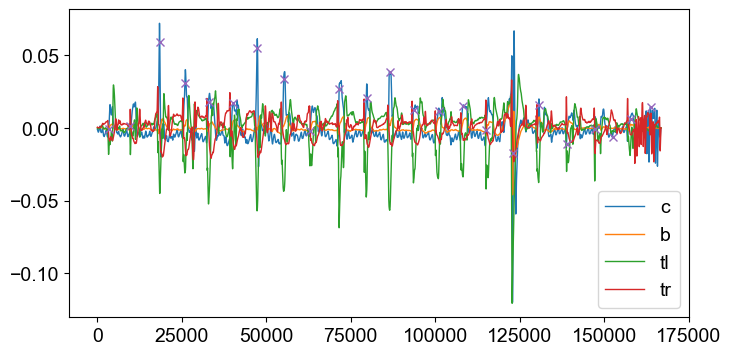

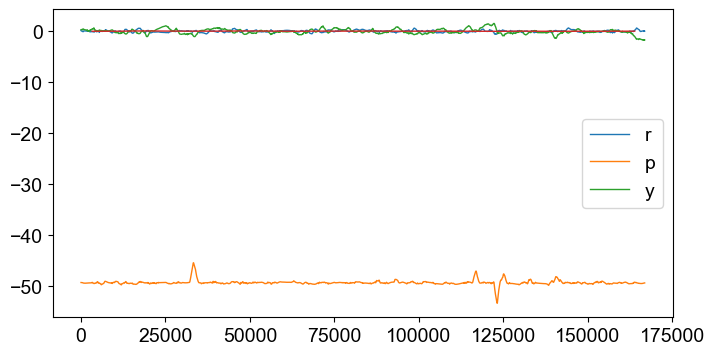

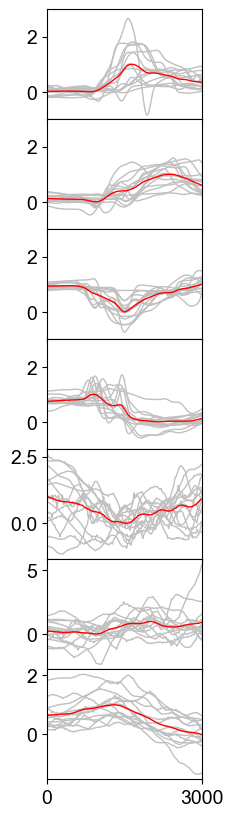

In [14]:
# deep breath
# Load
filename = filenames[0]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'tano', filename), delimiter=',', header=None)
timestamps, c, b, tl, tr, r, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
y = detrend(y, method='butter', fc=2)
r, p, y = despike(r, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, r, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(3, [0.1, 5], 'bandpass', output='sos', fs=1000) # for pvs
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)
sos = butter(2, [3, 7], 'bandstop', output='sos', fs=1000) # for angles
data[:, 4:] = sosfiltfilt(sos, data[:, 4:], axis=0)

# Find peaks
peaks, _ = find_peaks(-data[:, 2], distance=5000) # NOTE: Choose from seven channels to get the best result
plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, :4])
plt.plot(peaks, data[peaks, 0], 'x')
plt.legend(['c', 'b', 'tl', 'tr'])

plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, 4:])
plt.plot(peaks, data[peaks, 0])
plt.legend(['r', 'p', 'y'])

# Construct slices_0
window_width = 3000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))
slices_0 = []
for idx in range(expanded_peaks.shape[0]):
    slices_0.append(data[expanded_peaks[idx, :]])
slices_0 = np.array(slices_0)

# Create mask to filter outliers
# TODO: it should be easier to do the transpose -> (1, 0, 2) for all
mask = np.all(np.array([filter_windows(channel) for channel in np.transpose(slices_0,
                                                                            (1, 0, 2))]),
              axis=0)
slices_0 = slices_0[mask.astype(bool), :, :]
slices_0 = torch.tensor(np.transpose(slices_0, (0, 2, 1)))
labels_0 = torch.broadcast_to(torch.tensor(Label.DEEP_BREATH.value), (slices_0.shape[0], 1))
print(labels_0.shape)
print(slices_0.shape)

# Normalize after constructing slices using the average window as reference
slices_mean = torch.mean(slices_0, axis=0) # [n_ch, n_points]
slices_normalized = torch.zeros_like(slices_0)
slices_min = torch.zeros(slices_mean.shape[0])
amp_factors = torch.zeros(slices_mean.shape[0])
for ch in range(slices_mean.shape[0]):
    ch_max = torch.max(slices_mean[ch, :])
    ch_min = torch.min(slices_mean[ch, :])
    slices_min[ch] = ch_min
    amp_factors[ch] = 1 / (ch_max - ch_min)
for ch in range(slices_0.shape[1]):
    slices_normalized[:, ch, :] = (slices_0[:, ch, :] - slices_min[ch]) * amp_factors[ch]
slices_0 = slices_normalized

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(2, 10), sharex=True)
fig.subplots_adjust(hspace=0)
for ch, ax in enumerate(axes):
    for idx in range(slices_0.shape[0]):
        ax.plot(slices_0[idx, ch, :], 'silver')
    ax.plot((slices_mean[ch, :] - slices_min[ch]) * amp_factors[ch], 'r')
    ax.set_xlim(0, window_width)
    ax.set_xticks([0, window_width])
    if ch < 4:
        ax.set_ylim(-1, 3)
plt.show()

dry_cough.csv
torch.Size([18, 1])
torch.Size([18, 7, 3000])


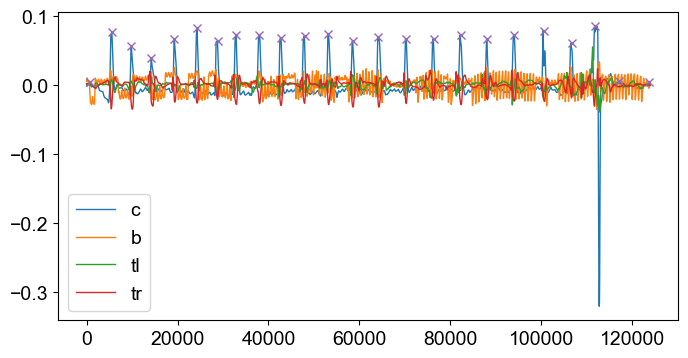

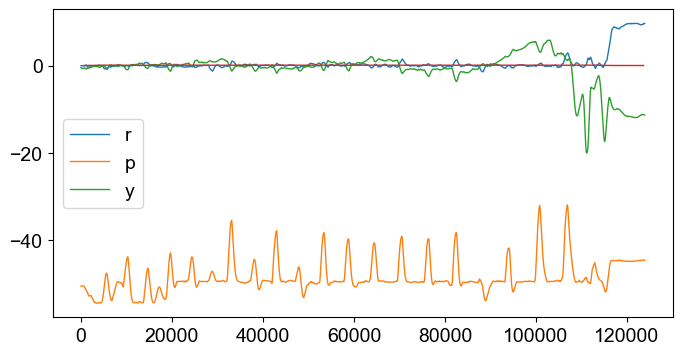

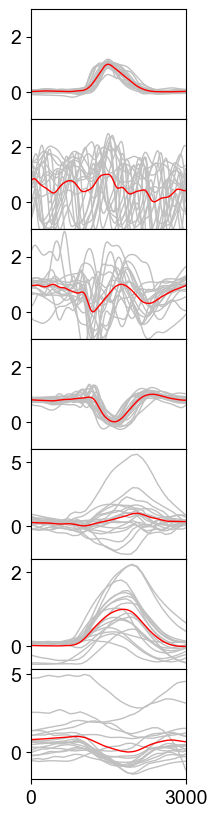

In [17]:
# dry cough
# Load
filename = filenames[1]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'tano', filename), delimiter=',', header=None)
timestamps, c, b, tl, tr, ch, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
y = detrend(y, method='butter', fc=2)
ch, p, y = despike(ch, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, ch, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(3, [0.1, 5], 'bandpass', output='sos', fs=1000) # for pvs
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)
sos = butter(2, [3, 7], 'bandstop', output='sos', fs=1000) # for angles
data[:, 4:] = sosfiltfilt(sos, data[:, 4:], axis=0)

# Find peaks
peaks, _ = find_peaks(data[:, 0], distance=4000)
plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, :4])
plt.plot(peaks, data[peaks, 0], 'x')
plt.legend(['c', 'b', 'tl', 'tr'])

plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, 4:])
plt.plot(peaks, data[peaks, 0])
plt.legend(['r', 'p', 'y'])

# Construct slices
window_width = 3000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))
slices_1 = []
for idx in range(expanded_peaks.shape[0]):
    slices_1.append(data[expanded_peaks[idx, :]])
slices_1 = np.array(slices_1)

# Create mask to filter outliers
# TODO: it should be easier to do the transpose -> (1, 0, 2) for all
mask = np.all(np.array([filter_windows(channel) for channel in np.transpose(slices_1,
                                                                            (1, 0, 2))]),
              axis=0)
slices_1 = slices_1[mask.astype(bool), :, :]
slices_1 = torch.tensor(np.transpose(slices_1, (0, 2, 1)))
labels_1 = torch.broadcast_to(torch.tensor(Label.DRY_COUGH.value), (slices_1.shape[0], 1))
print(labels_1.shape)
print(slices_1.shape)

# Normalize after constructing slices using the average window as reference
slices_mean = torch.mean(slices_1, axis=0) # [n_ch, n_points]
slices_normalized = torch.zeros_like(slices_1)
slices_min = torch.zeros(slices_mean.shape[0])
amp_factors = torch.zeros(slices_mean.shape[0])
for ch in range(slices_mean.shape[0]):
    ch_max = torch.max(slices_mean[ch, :])
    ch_min = torch.min(slices_mean[ch, :])
    slices_min[ch] = ch_min
    amp_factors[ch] = 1 / (ch_max - ch_min)
for ch in range(slices_1.shape[1]):
    slices_normalized[:, ch, :] = (slices_1[:, ch, :] - slices_min[ch]) * amp_factors[ch]
slices_1 = slices_normalized

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(2, 10), sharex=True)
fig.subplots_adjust(hspace=0)
for ch, ax in enumerate(axes):
    for idx in range(slices_1.shape[0]):
        ax.plot(slices_1[idx, ch, :], 'silver')
    ax.plot((slices_mean[ch, :] - slices_min[ch]) * amp_factors[ch], 'r')
    ax.set_xlim(0, window_width)
    ax.set_xticks([0, window_width])
    if ch < 4:
        ax.set_ylim(-1, 3)
plt.show()

jumping_jack.csv
torch.Size([13, 1])
torch.Size([13, 7, 3000])


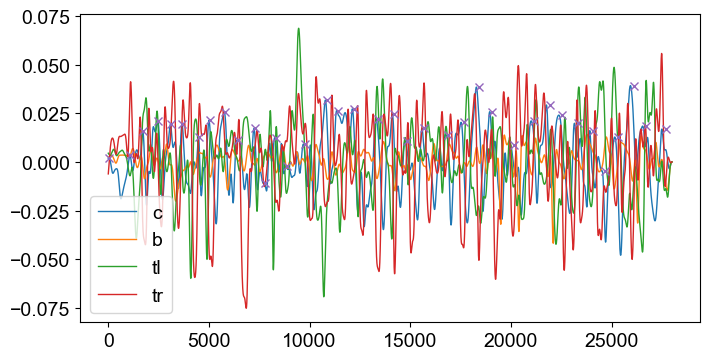

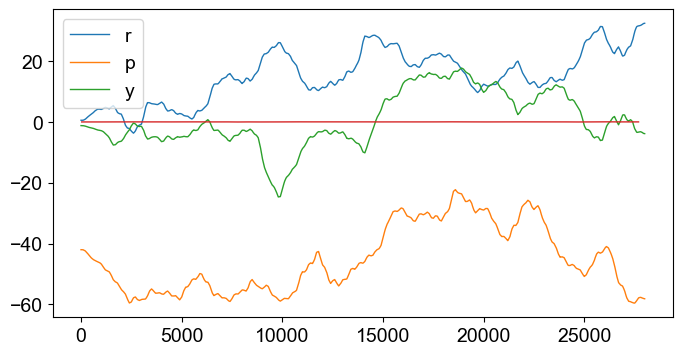

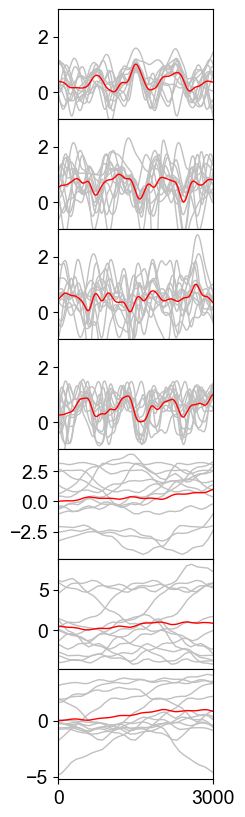

In [19]:
# jumping_jack
# Load
filename = filenames[2]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'tano', filename), delimiter=',', header=None)
data_raw = data_raw.truncate(after=280)
timestamps, c, b, tl, tr, ch, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
y = detrend(y, method='butter', fc=2)
ch, p, y = despike(ch, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, ch, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(3, [0.1, 5], 'bandpass', output='sos', fs=1000) # for pvs
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)
sos = butter(2, [3, 7], 'bandstop', output='sos', fs=1000) # for angles
data[:, 4:] = sosfiltfilt(sos, data[:, 4:], axis=0)

# Find peaks
peaks, _ = find_peaks(data[:, 0], distance=500)
plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, :4])
plt.plot(peaks, data[peaks, 0], 'x')
plt.legend(['c', 'b', 'tl', 'tr'])

plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, 4:])
plt.plot(peaks, data[peaks, 0])
plt.legend(['r', 'p', 'y'])

# Construct slices_0
window_width = 3000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))
slices_2 = []
for idx in range(expanded_peaks.shape[0]):
    slices_2.append(data[expanded_peaks[idx, :]])
slices_2 = np.array(slices_2)

# Create mask to filter outliers
mask = np.all(np.array([filter_windows(channel) for channel in np.transpose(slices_2,
                                                                            (1, 0, 2))]),
              axis=0)
slices_2 = slices_2[mask.astype(bool), :, :]
slices_2 = torch.tensor(np.transpose(slices_2, (0, 2, 1)))
labels_2 = torch.broadcast_to(torch.tensor(Label.JUMPING_JACK.value), (slices_2.shape[0], 1))
print(labels_2.shape)
print(slices_2.shape)

# Normalize after constructing slices using the average window as reference
slices_mean = torch.mean(slices_2, axis=0) # [n_ch, n_points]
slices_normalized = torch.zeros_like(slices_2)
slices_min = torch.zeros(slices_mean.shape[0])
amp_factors = torch.zeros(slices_mean.shape[0])
for ch in range(slices_mean.shape[0]):
    ch_max = torch.max(slices_mean[ch, :])
    ch_min = torch.min(slices_mean[ch, :])
    slices_min[ch] = ch_min
    amp_factors[ch] = 1 / (ch_max - ch_min)
for ch in range(slices_2.shape[1]):
    slices_normalized[:, ch, :] = (slices_2[:, ch, :] - slices_min[ch]) * amp_factors[ch]
slices_2 = slices_normalized

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(2, 10), sharex=True)
fig.subplots_adjust(hspace=0)
for ch, ax in enumerate(axes):
    for idx in range(slices_2.shape[0]):
        ax.plot(slices_2[idx, ch, :], 'silver')
    ax.plot((slices_mean[ch, :] - slices_min[ch]) * amp_factors[ch], 'r')
    ax.set_xlim(0, window_width)
    ax.set_xticks([0, window_width])
    if ch < 4:
        ax.set_ylim(-1, 3)
plt.show()

swallowing.csv
torch.Size([14, 1])
torch.Size([14, 7, 3000])


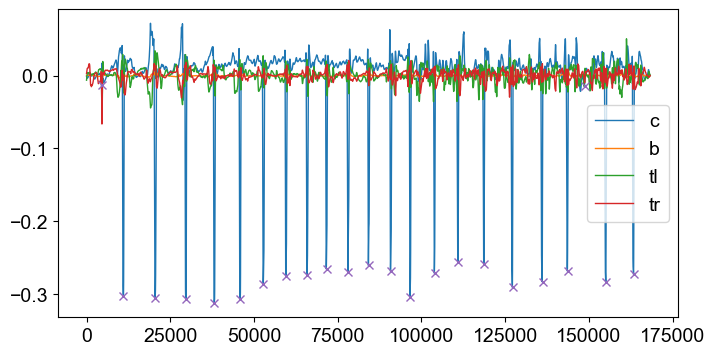

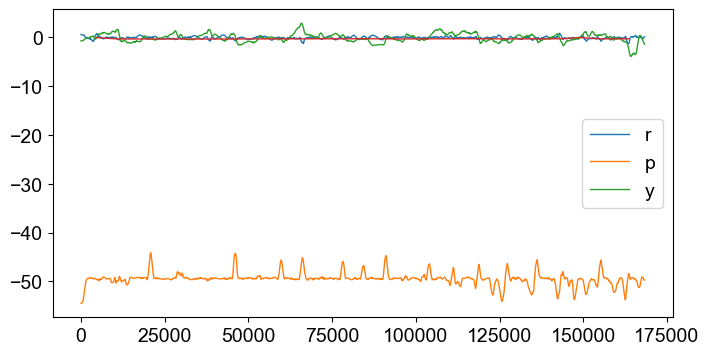

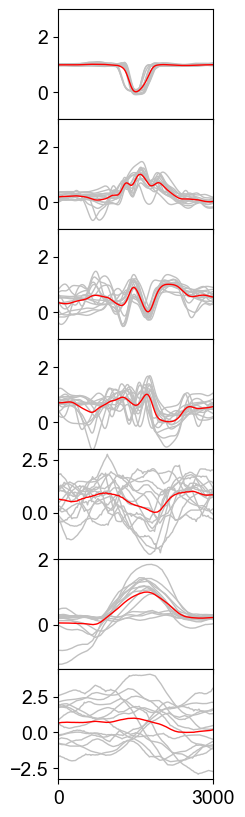

In [20]:
# swallowing
# Load
filename = filenames[5]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'tano', filename), delimiter=',', header=None)
timestamps, c, b, tl, tr, ch, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
y = detrend(y, method='butter', fc=2)
ch, p, y = despike(ch, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, ch, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(3, [0.1, 5], 'bandpass', output='sos', fs=1000) # for pvs
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)
sos = butter(2, [3, 7], 'bandstop', output='sos', fs=1000) # for angles
data[:, 4:] = sosfiltfilt(sos, data[:, 4:], axis=0)

# Find peaks
peaks, _ = find_peaks(-data[:, 0], distance=5000)
plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, :4])
plt.plot(peaks, data[peaks, 0], 'x')
plt.legend(['c', 'b', 'tl', 'tr'])

plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, 4:])
plt.plot(peaks, data[peaks, 0])
plt.legend(['r', 'p', 'y'])

# Construct slices_3
window_width = 3000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))

slices_3 = []
for idx in range(expanded_peaks.shape[0]):
    slices_3.append(data[expanded_peaks[idx, :]])
slices_3 = np.array(slices_3)
mask = np.all(np.array([filter_windows(channel) for channel in np.transpose(slices_3,
                                                                            (1, 0, 2))]),
              axis=0)
slices_3 = slices_3[mask.astype(bool), :, :]
slices_3 = torch.tensor(np.transpose(slices_3, (0, 2, 1)))
labels_3 = torch.broadcast_to(torch.tensor(Label.SWALLOWING.value), (slices_3.shape[0], 1))
print(labels_3.shape)
print(slices_3.shape)

# Normalize after constructing slices using the average window as reference
slices_mean = torch.mean(slices_3, axis=0) # [n_ch, n_points]
slices_normalized = torch.zeros_like(slices_3)
slices_min = torch.zeros(slices_mean.shape[0])
amp_factors = torch.zeros(slices_mean.shape[0])
for ch in range(slices_mean.shape[0]):
    ch_max = torch.max(slices_mean[ch, :])
    ch_min = torch.min(slices_mean[ch, :])
    slices_min[ch] = ch_min
    amp_factors[ch] = 1 / (ch_max - ch_min)
for ch in range(slices_3.shape[1]):
    slices_normalized[:, ch, :] = (slices_3[:, ch, :] - slices_min[ch]) * amp_factors[ch]
slices_3 = slices_normalized

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(2, 10), sharex=True)
fig.subplots_adjust(hspace=0)
for ch, ax in enumerate(axes):
    for idx in range(slices_3.shape[0]):
        ax.plot(slices_3[idx, ch, :], 'silver')
    ax.plot((slices_mean[ch, :] - slices_min[ch]) * amp_factors[ch], 'r')
    ax.set_xlim(0, window_width)
    ax.set_xticks([0, window_width])
    if ch < 4:
        ax.set_ylim(-1, 3)
plt.show()

push_up.csv
torch.Size([24, 1])
torch.Size([24, 7, 3000])


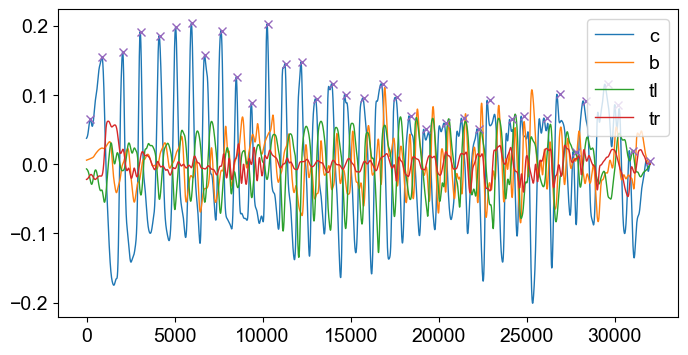

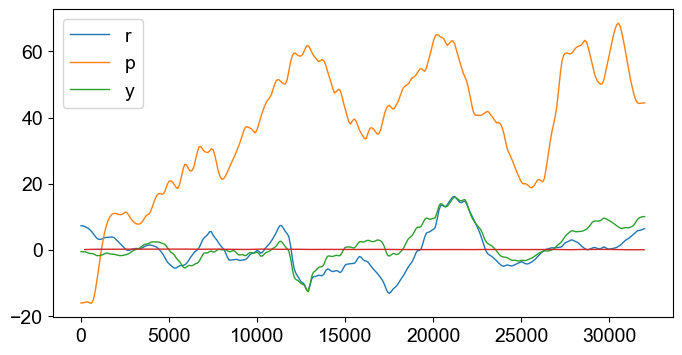

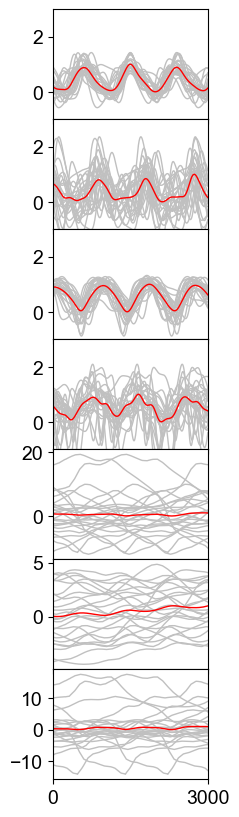

In [22]:
# push up
# Load
filename = filenames[3]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'tano', filename), delimiter=',', header=None)
data_raw = data_raw.truncate(after=320)
timestamps, c, b, tl, tr, ch, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
y = detrend(y, method='butter', fc=2)
ch, p, y = despike(ch, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, ch, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(3, [0.1, 5], 'bandpass', output='sos', fs=1000) # for pvs
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)
sos = butter(2, [3, 7], 'bandstop', output='sos', fs=1000) # for angles
data[:, 4:] = sosfiltfilt(sos, data[:, 4:], axis=0)

# Find peaks
peaks, _ = find_peaks(data[:, 0], distance=500)
plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, :4])
plt.plot(peaks, data[peaks, 0], 'x')
plt.legend(['c', 'b', 'tl', 'tr'])

plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, 4:])
plt.plot(peaks, data[peaks, 0])
plt.legend(['r', 'p', 'y'])

# Construct slices_4
window_width = 3000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))

slices_4 = []
for idx in range(expanded_peaks.shape[0]):
    slices_4.append(data[expanded_peaks[idx, :]])
slices_4 = np.array(slices_4)
mask = np.all(np.array([filter_windows(channel) for channel in np.transpose(slices_4,
                                                                            (1, 0, 2))]),
              axis=0)
slices_4 = slices_4[mask.astype(bool), :, :]
slices_4 = torch.tensor(np.transpose(slices_4, (0, 2, 1)))
labels_4 = torch.broadcast_to(torch.tensor(Label.PUSH_UP.value), (slices_4.shape[0], 1))
print(labels_4.shape)
print(slices_4.shape)

# Normalize after constructing slices using the average window as reference
slices_mean = torch.mean(slices_4, axis=0) # [n_ch, n_points]
slices_normalized = torch.zeros_like(slices_4)
slices_min = torch.zeros(slices_mean.shape[0])
amp_factors = torch.zeros(slices_mean.shape[0])
for ch in range(slices_mean.shape[0]):
    ch_max = torch.max(slices_mean[ch, :])
    ch_min = torch.min(slices_mean[ch, :])
    slices_min[ch] = ch_min
    amp_factors[ch] = 1 / (ch_max - ch_min)
for ch in range(slices_4.shape[1]):
    slices_normalized[:, ch, :] = (slices_4[:, ch, :] - slices_min[ch]) * amp_factors[ch]
slices_4 = slices_normalized

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(2, 10), sharex=True)
fig.subplots_adjust(hspace=0)
for ch, ax in enumerate(axes):
    for idx in range(slices_4.shape[0]):
        ax.plot(slices_4[idx, ch, :], 'silver')
    ax.plot((slices_mean[ch, :] - slices_min[ch]) * amp_factors[ch], 'r')
    ax.set_xlim(0, window_width)
    ax.set_xticks([0, window_width])
    if ch < 4:
        ax.set_ylim(-1, 3)
plt.show()

throat_clearing.csv
torch.Size([16, 1])
torch.Size([16, 7, 3000])


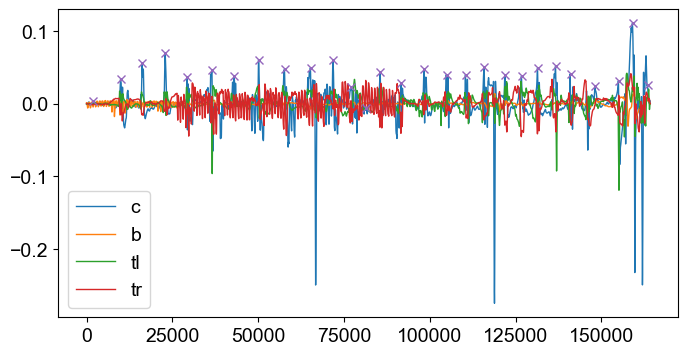

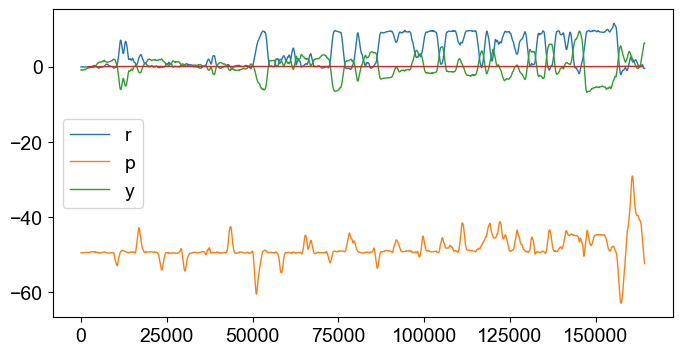

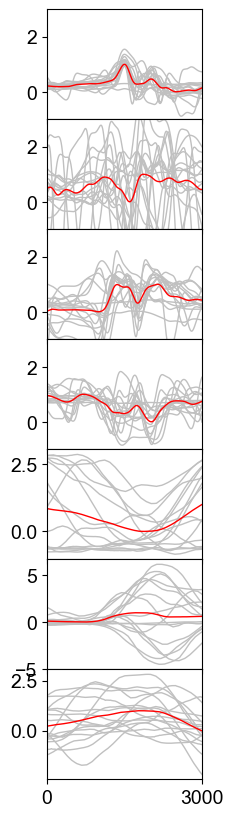

In [23]:
# throat clearing
# Load
filename = filenames[6]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'tano', filename), delimiter=',', header=None)
timestamps, c, b, tl, tr, ch, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
y = detrend(y, method='butter', fc=2)
ch, p, y = despike(ch, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, ch, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(3, [0.1, 5], 'bandpass', output='sos', fs=1000) # for pvs
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)
sos = butter(2, [3, 7], 'bandstop', output='sos', fs=1000) # for angles
data[:, 4:] = sosfiltfilt(sos, data[:, 4:], axis=0)

# Find peaks
peaks, _ = find_peaks(data[:, 0], distance=4000)
plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, :4])
plt.plot(peaks, data[peaks, 0], 'x')
plt.legend(['c', 'b', 'tl', 'tr'])

plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, 4:])
plt.plot(peaks, data[peaks, 0])
plt.legend(['r', 'p', 'y'])


# Construct slices_5
window_width = 3000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))

slices_5 = []
for idx in range(expanded_peaks.shape[0]):
    slices_5.append(data[expanded_peaks[idx, :]])
slices_5 = np.array(slices_5)
mask = np.all(np.array([filter_windows(channel) for channel in np.transpose(slices_5,
                                                                            (1, 0, 2))]),
              axis=0)
slices_5 = slices_5[mask.astype(bool), :, :]
slices_5 = torch.tensor(np.transpose(slices_5, (0, 2, 1)))
labels_5 = torch.broadcast_to(torch.tensor(Label.THROAT_CLEARING.value), (slices_5.shape[0], 1))
print(labels_5.shape)
print(slices_5.shape)

# Normalize after constructing slices using the average window as reference
slices_mean = torch.mean(slices_5, axis=0) # [n_ch, n_points]
slices_normalized = torch.zeros_like(slices_5)
slices_min = torch.zeros(slices_mean.shape[0])
amp_factors = torch.zeros(slices_mean.shape[0])
for ch in range(slices_mean.shape[0]):
    ch_max = torch.max(slices_mean[ch, :])
    ch_min = torch.min(slices_mean[ch, :])
    slices_min[ch] = ch_min
    amp_factors[ch] = 1 / (ch_max - ch_min)
for ch in range(slices_5.shape[1]):
    slices_normalized[:, ch, :] = (slices_5[:, ch, :] - slices_min[ch]) * amp_factors[ch]
slices_5 = slices_normalized

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(2, 10), sharex=True)
fig.subplots_adjust(hspace=0)
for ch, ax in enumerate(axes):
    for idx in range(slices_5.shape[0]):
        ax.plot(slices_5[idx, ch, :], 'silver')
    ax.plot((slices_mean[ch, :] - slices_min[ch]) * amp_factors[ch], 'r')
    ax.set_xlim(0, window_width)
    ax.set_xticks([0, window_width])
    if ch < 4:
        ax.set_ylim(-1, 3)
plt.show()

___
**Dataset forming**

In [24]:
all_slices = torch.cat((slices_0, slices_1, slices_2, slices_3, slices_4, slices_5), dim=0)
all_labels = torch.cat((labels_0, labels_1, labels_2, labels_3, labels_4, labels_5), dim=0)
print(all_slices.shape)
print(all_labels.shape)

torch.Size([99, 7, 3000])
torch.Size([99, 1])


In [2]:
class BaseLHMDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.shape[0]

class LHMPVBiasedDataset(BaseLHMDataset):
    def __getitem__(self, idx):
        return self.features[idx, :4, :].transpose(0, 1).float(), self.labels[idx]

class LHMIMUBiasedDataset(BaseLHMDataset):
    def __getitem__(self, idx):
        return self.features[idx, 4:, :].transpose(0, 1).float(), self.labels[idx]

class LHMMonoDataset(BaseLHMDataset):
    def __getitem__(self, idx):
        return self.features[idx, ...].transpose(0, 1).float(), self.labels[idx]

class LHMDualDataset(BaseLHMDataset):
    def __getitem__(self, idx):
        photovoltage_data = self.features[idx, :4, :].float().transpose(0, 1)  # First 4 channels
        euler_angle_data = self.features[idx, 4:, :].float().transpose(0, 1)  # Last 3 channels
        return photovoltage_data, euler_angle_data, self.labels[idx]

In [26]:
pv_biased_ds = LHMPVBiasedDataset(all_slices, all_labels)
torch.save(pv_biased_ds, '../dataset/preprocessed/pv_biased.pt')

imu_biased_ds = LHMIMUBiasedDataset(all_slices, all_labels)
torch.save(imu_biased_ds, '../dataset/preprocessed/imu_biased.pt')

mono_ds = LHMMonoDataset(all_slices, all_labels)
torch.save(mono_ds, '../dataset/preprocessed/mono.pt')

dual_ds = LHMDualDataset(all_slices, all_labels)
torch.save(dual_ds, '../dataset/preprocessed/dual.pt')

___
**Training**

In [3]:
pv_biased_ds = torch.load('../dataset/preprocessed/pv_biased.pt')
imu_biased_ds = torch.load('../dataset/preprocessed/imu_biased.pt')
mono_ds = torch.load('../dataset/preprocessed/mono.pt')
dual_ds = torch.load('../dataset/preprocessed/dual.pt')

print(dual_ds.features.shape)
print(dual_ds.labels.shape)

torch.Size([99, 7, 3000])
torch.Size([99, 1])


In [45]:
class BaseLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(BaseLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        num_directions = 2 if self.lstm.bidirectional else 1
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.layer_dim * num_directions, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.layer_dim * num_directions, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach())) # hn, cn are here as placeholder
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        return out

class PVBiasedLSTMModel(BaseLSTMModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(PVBiasedLSTMModel, self).__init__(4, hidden_dim, layer_dim, output_dim)

class PVBiasedBiLSTMModel(BaseLSTMModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(PVBiasedBiLSTMModel, self).__init__(4, hidden_dim, layer_dim, output_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

class IMUBiasedLSTMModel(BaseLSTMModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(IMUBiasedLSTMModel, self).__init__(3, hidden_dim, layer_dim, output_dim)

class IMUBiasedBiLSTMModel(BaseLSTMModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(IMUBiasedBiLSTMModel, self).__init__(3, hidden_dim, layer_dim, output_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

class MonoLSTMModel(BaseLSTMModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(MonoLSTMModel, self).__init__(7, hidden_dim, layer_dim, output_dim)

class MonoBiLSTMModel(BaseLSTMModel):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(MonoBiLSTMModel, self).__init__(7, hidden_dim, layer_dim, output_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

class DualLSTMModel(nn.Module):
    def __init__(self, input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(DualLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.dropout_prob = dropout_prob

        self.lstm1 = nn.LSTM(input_dim1, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        self.lstm2 = nn.LSTM(input_dim2, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):
        # Initialize hidden states and cell states for both LSTMs
        h01 = torch.zeros(self.layer_dim, x1.size(0), self.hidden_dim).requires_grad_().to(device)
        c01 = torch.zeros(self.layer_dim, x1.size(0), self.hidden_dim).requires_grad_().to(device)

        h02 = torch.zeros(self.layer_dim, x2.size(0), self.hidden_dim).requires_grad_().to(device)
        c02 = torch.zeros(self.layer_dim, x2.size(0), self.hidden_dim).requires_grad_().to(device)

        out1, _ = self.lstm1(x1, (h01.detach(), c01.detach()))
        out2, _ = self.lstm2(x2, (h02.detach(), c02.detach()))

        # Concatenate the outputs from both LSTMs
        out = torch.cat((out1[:, -1, :], out2[:, -1, :]), 1)

        out = self.fc(out)
        out = self.softmax(out)
        return out

class DualBiLSTMModel(nn.Module):
    def __init__(self, input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(DualBiLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.dropout_prob = dropout_prob

        self.lstm1 = nn.LSTM(input_dim1, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=True)
        self.lstm2 = nn.LSTM(input_dim2, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):
        # Initialize hidden states and cell states for both LSTMs
        h01 = torch.zeros(self.layer_dim * 2, x1.size(0), self.hidden_dim).requires_grad_().to(device)
        c01 = torch.zeros(self.layer_dim * 2, x1.size(0), self.hidden_dim).requires_grad_().to(device)

        h02 = torch.zeros(self.layer_dim * 2, x2.size(0), self.hidden_dim).requires_grad_().to(device)
        c02 = torch.zeros(self.layer_dim * 2, x2.size(0), self.hidden_dim).requires_grad_().to(device)

        out1, _ = self.lstm1(x1, (h01.detach(), c01.detach()))
        out2, _ = self.lstm2(x2, (h02.detach(), c02.detach()))

        # Concatenate the outputs from both LSTMs
        out = torch.cat((out1[:, -1, :], out2[:, -1, :]), 1)

        out = self.fc(out)
        out = self.softmax(out)
        return out

In [85]:
input_dim1 = 4 # For photovoltage data
input_dim2 = 3 # For Euler angle data
hidden_dim = 140
layer_dim = 1
output_dim = 6 # Number of classes
dropout_prob = 0.1

num_epochs = 400

# Number of folds for cross-validation
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=42)
dataset_indices = list(range(len(dual_ds)))

# Preparing data
batch_size = 32

total_samples = len(pv_biased_ds)
test_size = int(0.3 * total_samples)
train_size = total_samples - test_size

train_dataset_pv_biased, test_dataset_pv_biased = random_split(pv_biased_ds, [train_size, test_size])
train_loader_pv_biased = DataLoader(train_dataset_pv_biased, batch_size=batch_size, shuffle=True)
test_loader_pv_biased = DataLoader(test_dataset_pv_biased, batch_size=batch_size, shuffle=False)

train_dataset_pv_biased_bi, test_dataset_pv_biased_bi = random_split(pv_biased_ds, [train_size, test_size])
train_loader_pv_biased_bi = DataLoader(train_dataset_pv_biased_bi, batch_size=batch_size, shuffle=True)
test_loader_pv_biased_bi = DataLoader(test_dataset_pv_biased_bi, batch_size=batch_size, shuffle=False)

train_dataset_imu_biased, test_dataset_imu_biased = random_split(imu_biased_ds, [train_size, test_size])
train_loader_imu_biased = DataLoader(train_dataset_imu_biased, batch_size=batch_size, shuffle=True)
test_loader_imu_biased = DataLoader(test_dataset_imu_biased, batch_size=batch_size, shuffle=False)

train_dataset_imu_biased_bi, test_dataset_imu_biased_bi = random_split(imu_biased_ds, [train_size, test_size])
train_loader_imu_biased_bi = DataLoader(train_dataset_imu_biased_bi, batch_size=batch_size, shuffle=True)
test_loader_imu_biased_bi = DataLoader(test_dataset_imu_biased_bi, batch_size=batch_size, shuffle=False)

train_dataset_mono, test_dataset_mono = random_split(mono_ds, [train_size, test_size])
train_loader_mono = DataLoader(train_dataset_mono, batch_size=batch_size, shuffle=True)
test_loader_mono = DataLoader(test_dataset_mono, batch_size=batch_size, shuffle=False)

train_dataset_mono_bi, test_dataset_mono_bi = random_split(mono_ds, [train_size, test_size])
train_loader_mono_bi = DataLoader(train_dataset_mono_bi, batch_size=batch_size, shuffle=True)
test_loader_mono_bi = DataLoader(test_dataset_mono_bi, batch_size=batch_size, shuffle=False)

train_dataset_dual, test_dataset_dual = random_split(dual_ds, [train_size, test_size])
train_loader_dual = DataLoader(train_dataset_dual, batch_size=batch_size, shuffle=True)
test_loader_dual = DataLoader(test_dataset_dual, batch_size=batch_size, shuffle=False)

train_dataset_dual_bi, test_dataset_dual_bi = random_split(dual_ds, [train_size, test_size])
train_loader_dual_bi = DataLoader(train_dataset_dual_bi, batch_size=batch_size, shuffle=True)
test_loader_dual_bi = DataLoader(test_dataset_dual_bi, batch_size=batch_size, shuffle=False)

In [10]:
# Container for losses and accuracies
train_losses_pv_biased = [[] for _ in range(k)]
train_accuracies_pv_biased = [[] for _ in range(k)]
test_losses_pv_biased = [[] for _ in range(k)]
test_accuracies_pv_biased = [[] for _ in range(k)]


for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')
    
    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_pv_biased = DataLoader(pv_biased_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_pv_biased = DataLoader(pv_biased_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_pv_biased = PVBiasedLSTMModel(input_dim1, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_pv_biased = torch.optim.Adam(model_pv_biased.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_pv_biased.to(device))

    for epoch in range(num_epochs):
        model_pv_biased.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_pv_biased:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_pv_biased(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_pv_biased.zero_grad()
            loss.backward()
            optimizer_pv_biased.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_pv_biased)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_pv_biased[fold].append(avg_train_loss)
        train_accuracies_pv_biased[fold].append(train_accuracy)

        model_pv_biased.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_pv_biased:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_pv_biased(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_pv_biased)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_pv_biased[fold].append(avg_test_loss)
        test_accuracies_pv_biased[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

---------------
In Fold 0
---------------
PVBiasedLSTMModel(
  (lstm): LSTM(4, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.8025, Train Accuracy: 0.1266, Test Loss: 1.7971, Test Accuracy: 0.1500
Epoch [10/400], Train Loss: 1.8038, Train Accuracy: 0.1266, Test Loss: 1.7948, Test Accuracy: 0.1500
Epoch [15/400], Train Loss: 1.7949, Train Accuracy: 0.1266, Test Loss: 1.7926, Test Accuracy: 0.1500
Epoch [20/400], Train Loss: 1.7962, Train Accuracy: 0.1266, Test Loss: 1.7906, Test Accuracy: 0.1500
Epoch [25/400], Train Loss: 1.7901, Train Accuracy: 0.1266, Test Loss: 1.7885, Test Accuracy: 0.1500
Epoch [30/400], Train Loss: 1.7890, Train Accuracy: 0.1266, Test Loss: 1.7864, Test Accuracy: 0.1500
Epoch [35/400], Train Loss: 1.7890, Train Accuracy: 0.1266, Test Loss: 1.7846, Test Accuracy: 0.1500
Epoch [40/400], Train Loss: 1.7786, Train Accuracy: 0.1266, Test Loss: 1.7829, Test Accuracy: 0.1500

In [11]:
# Container for losses and accuracies
train_losses_pv_biased_bi = [[] for _ in range(k)]
train_accuracies_pv_biased_bi = [[] for _ in range(k)]
test_losses_pv_biased_bi = [[] for _ in range(k)]
test_accuracies_pv_biased_bi = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_pv_biased_bi = DataLoader(pv_biased_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_pv_biased_bi = DataLoader(pv_biased_ds, batch_size=batch_size, sampler=train_subsmapler)

    # Model definition
    model_pv_biased_bi = PVBiasedBiLSTMModel(input_dim1, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_pv_biased_bi = torch.optim.Adam(model_pv_biased_bi.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_pv_biased_bi.to(device))

    for epoch in range(num_epochs):
        model_pv_biased_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_pv_biased_bi:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_pv_biased_bi(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_pv_biased_bi.zero_grad()
            loss.backward()
            optimizer_pv_biased_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_pv_biased_bi)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_pv_biased_bi[fold].append(avg_train_loss)
        train_accuracies_pv_biased_bi[fold].append(train_accuracy)

        model_pv_biased_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_pv_biased_bi:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_pv_biased_bi(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_pv_biased_bi)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_pv_biased_bi[fold].append(avg_test_loss)
        test_accuracies_pv_biased_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

---------------
In Fold 0
---------------
PVBiasedBiLSTMModel(
  (lstm): LSTM(4, 100, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=200, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7882, Train Accuracy: 0.1519, Test Loss: 1.7877, Test Accuracy: 0.1519
Epoch [10/400], Train Loss: 1.7822, Train Accuracy: 0.1646, Test Loss: 1.7779, Test Accuracy: 0.1646
Epoch [15/400], Train Loss: 1.7787, Train Accuracy: 0.1772, Test Loss: 1.7819, Test Accuracy: 0.1772
Epoch [20/400], Train Loss: 1.7757, Train Accuracy: 0.1772, Test Loss: 1.7794, Test Accuracy: 0.1772
Epoch [25/400], Train Loss: 1.7726, Train Accuracy: 0.1772, Test Loss: 1.7699, Test Accuracy: 0.1772
Epoch [30/400], Train Loss: 1.7692, Train Accuracy: 0.1772, Test Loss: 1.7699, Test Accuracy: 0.1772
Epoch [35/400], Train Loss: 1.7688, Train Accuracy: 0.1899, Test Loss: 1.7665, Test Accuracy: 0.1899
Epoch [40/400], Train Loss: 1.7597, Train Accuracy: 0.2532, Test Loss: 1.7603,

In [12]:
# Container for losses and accuracies
train_losses_imu_biased = [[] for _ in range(k)]
train_accuracies_imu_biased = [[] for _ in range(k)]
test_losses_imu_biased = [[] for _ in range(k)]
test_accuracies_imu_biased = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_imu_biased = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_imu_biased = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_imu_biased = IMUBiasedLSTMModel(input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_imu_biased = torch.optim.Adam(model_imu_biased.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_imu_biased.to(device))

    for epoch in range(num_epochs):
        model_imu_biased.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_imu_biased:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_imu_biased(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_imu_biased.zero_grad()
            loss.backward()
            optimizer_imu_biased.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_imu_biased)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_imu_biased[fold].append(avg_train_loss)
        train_accuracies_imu_biased[fold].append(train_accuracy)

        model_imu_biased.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_imu_biased:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_imu_biased(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_imu_biased)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_imu_biased[fold].append(avg_test_loss)
        test_accuracies_imu_biased[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

---------------
In Fold 0
---------------
IMUBiasedLSTMModel(
  (lstm): LSTM(3, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7874, Train Accuracy: 0.1899, Test Loss: 1.7833, Test Accuracy: 0.2000
Epoch [10/400], Train Loss: 1.7819, Train Accuracy: 0.1899, Test Loss: 1.7790, Test Accuracy: 0.3500
Epoch [15/400], Train Loss: 1.7723, Train Accuracy: 0.2152, Test Loss: 1.7751, Test Accuracy: 0.4000
Epoch [20/400], Train Loss: 1.7718, Train Accuracy: 0.2532, Test Loss: 1.7712, Test Accuracy: 0.3500
Epoch [25/400], Train Loss: 1.7636, Train Accuracy: 0.2532, Test Loss: 1.7674, Test Accuracy: 0.3500
Epoch [30/400], Train Loss: 1.7548, Train Accuracy: 0.2658, Test Loss: 1.7631, Test Accuracy: 0.3500
Epoch [35/400], Train Loss: 1.7596, Train Accuracy: 0.2785, Test Loss: 1.7590, Test Accuracy: 0.3500
Epoch [40/400], Train Loss: 1.7421, Train Accuracy: 0.2911, Test Loss: 1.7550, Test Accuracy: 0.400

In [13]:
# Container for losses and accuracies
train_losses_imu_biased_bi = [[] for _ in range(k)]
train_accuracies_imu_biased_bi = [[] for _ in range(k)]
test_losses_imu_biased_bi = [[] for _ in range(k)]
test_accuracies_imu_biased_bi = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_imu_biased_bi = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_imu_biased_bi = DataLoader(imu_biased_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_imu_biased_bi = IMUBiasedBiLSTMModel(input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_imu_biased_bi = torch.optim.Adam(model_imu_biased_bi.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_imu_biased_bi.to(device))

    for epoch in range(num_epochs):
        model_imu_biased_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_imu_biased_bi:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_imu_biased_bi(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_imu_biased_bi.zero_grad()
            loss.backward()
            optimizer_imu_biased_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_imu_biased)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_imu_biased_bi[fold].append(avg_train_loss)
        train_accuracies_imu_biased_bi[fold].append(train_accuracy)

        model_imu_biased_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_imu_biased_bi:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_imu_biased_bi(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_imu_biased)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_imu_biased_bi[fold].append(avg_test_loss)
        test_accuracies_imu_biased_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

---------------
In Fold 0
---------------
IMUBiasedBiLSTMModel(
  (lstm): LSTM(3, 100, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=200, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7870, Train Accuracy: 0.2278, Test Loss: 1.7826, Test Accuracy: 0.2000
Epoch [10/400], Train Loss: 1.7853, Train Accuracy: 0.2278, Test Loss: 1.7775, Test Accuracy: 0.2000
Epoch [15/400], Train Loss: 1.7751, Train Accuracy: 0.2405, Test Loss: 1.7722, Test Accuracy: 0.2500
Epoch [20/400], Train Loss: 1.7727, Train Accuracy: 0.2785, Test Loss: 1.7681, Test Accuracy: 0.3000
Epoch [25/400], Train Loss: 1.7627, Train Accuracy: 0.3038, Test Loss: 1.7641, Test Accuracy: 0.4000
Epoch [30/400], Train Loss: 1.7606, Train Accuracy: 0.3924, Test Loss: 1.7602, Test Accuracy: 0.4000
Epoch [35/400], Train Loss: 1.7572, Train Accuracy: 0.4177, Test Loss: 1.7565, Test Accuracy: 0.4500
Epoch [40/400], Train Loss: 1.7476, Train Accuracy: 0.4051, Test Loss: 1.7526

In [14]:
# Container for losses and accuracies
train_losses_mono = [[] for _ in range(k)]
train_accuracies_mono = [[] for _ in range(k)]
test_losses_mono = [[] for _ in range(k)]
test_accuracies_mono = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_mono = DataLoader(mono_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_mono = DataLoader(mono_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_mono = MonoLSTMModel(input_dim1+input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_mono = torch.optim.Adam(model_mono.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_mono.to(device))

    for epoch in range(num_epochs):
        model_mono.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_mono:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_mono(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_mono.zero_grad()
            loss.backward()
            optimizer_mono.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_mono)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_mono[fold].append(avg_train_loss)
        train_accuracies_mono[fold].append(train_accuracy)

        model_mono.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_mono:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_mono(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_mono)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_mono[fold].append(avg_test_loss)
        test_accuracies_mono[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], '
            f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
            f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

---------------
In Fold 0
---------------
MonoLSTMModel(
  (lstm): LSTM(7, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [1/400], Train Loss: 1.7826, Train Accuracy: 0.1013, Test Loss: 1.8008, Test Accuracy: 0.0500
Epoch [2/400], Train Loss: 1.7792, Train Accuracy: 0.1139, Test Loss: 1.7995, Test Accuracy: 0.0500
Epoch [3/400], Train Loss: 1.7790, Train Accuracy: 0.1139, Test Loss: 1.7983, Test Accuracy: 0.0500
Epoch [4/400], Train Loss: 1.7767, Train Accuracy: 0.1139, Test Loss: 1.7970, Test Accuracy: 0.0500
Epoch [5/400], Train Loss: 1.7742, Train Accuracy: 0.1139, Test Loss: 1.7958, Test Accuracy: 0.1000
Epoch [6/400], Train Loss: 1.7729, Train Accuracy: 0.1139, Test Loss: 1.7946, Test Accuracy: 0.1000
Epoch [7/400], Train Loss: 1.7712, Train Accuracy: 0.1013, Test Loss: 1.7933, Test Accuracy: 0.1000
Epoch [8/400], Train Loss: 1.7729, Train Accuracy: 0.1139, Test Loss: 1.7921, Test Accuracy: 0.1000
Epoch [9/4

In [15]:
# Container for losses and accuracies
train_losses_mono_bi = [[] for _ in range(k)]
train_accuracies_mono_bi = [[] for _ in range(k)]
test_losses_mono_bi = [[] for _ in range(k)]
test_accuracies_mono_bi = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_mono_bi = DataLoader(mono_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_mono_bi = DataLoader(mono_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_mono_bi = MonoBiLSTMModel(input_dim1+input_dim2, hidden_dim, layer_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer_mono_bi = torch.optim.Adam(model_mono_bi.parameters(), lr=0.0001, weight_decay=0.022)
    print(model_mono_bi.to(device))

    for epoch in range(num_epochs):
        model_mono_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for samples, labels in train_loader_mono_bi:
            # Load data
            samples = samples.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_mono_bi(samples)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_mono_bi.zero_grad()
            loss.backward()
            optimizer_mono_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_mono_bi)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_mono_bi[fold].append(avg_train_loss)
        train_accuracies_mono_bi[fold].append(train_accuracy)

        model_mono_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for samples, labels in test_loader_mono_bi:
                # Load data
                samples = samples.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model_mono_bi(samples)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_mono_bi)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_mono_bi[fold].append(avg_test_loss)
        test_accuracies_mono_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

---------------
In Fold 0
---------------
MonoBiLSTMModel(
  (lstm): LSTM(7, 100, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=200, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7836, Train Accuracy: 0.2278, Test Loss: 1.7930, Test Accuracy: 0.0500
Epoch [10/400], Train Loss: 1.7772, Train Accuracy: 0.2785, Test Loss: 1.7862, Test Accuracy: 0.0500
Epoch [15/400], Train Loss: 1.7657, Train Accuracy: 0.3038, Test Loss: 1.7796, Test Accuracy: 0.1500
Epoch [20/400], Train Loss: 1.7582, Train Accuracy: 0.3797, Test Loss: 1.7738, Test Accuracy: 0.2500
Epoch [25/400], Train Loss: 1.7568, Train Accuracy: 0.4937, Test Loss: 1.7677, Test Accuracy: 0.2500
Epoch [30/400], Train Loss: 1.7440, Train Accuracy: 0.5316, Test Loss: 1.7619, Test Accuracy: 0.3000
Epoch [35/400], Train Loss: 1.7391, Train Accuracy: 0.5570, Test Loss: 1.7563, Test Accuracy: 0.3500
Epoch [40/400], Train Loss: 1.7239, Train Accuracy: 0.5570, Test Loss: 1.7504, Tes

In [86]:
# Container for losses and accuracies
train_losses_dual = [[] for _ in range(k)]
train_accuracies_dual = [[] for _ in range(k)]
test_losses_dual = [[] for _ in range(k)]
test_accuracies_dual = [[] for _ in range(k)]

for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')

    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_dual = DataLoader(dual_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_dual = DataLoader(dual_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_dual = DualLSTMModel(input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob)
    criterion = nn.CrossEntropyLoss()
    optimizer_dual = torch.optim.Adam(model_dual.parameters(), lr=0.0001, weight_decay=0.01)
    print(model_dual.to(device))

    for epoch in range(num_epochs):
        model_dual.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for photovoltage_data, euler_angle_data, labels in train_loader_dual:
            # Load data
            photovoltage_data = photovoltage_data.to(device)
            euler_angle_data = euler_angle_data.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_dual(photovoltage_data, euler_angle_data)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_dual.zero_grad()
            loss.backward()
            optimizer_dual.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_dual)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_dual[fold].append(avg_train_loss)
        train_accuracies_dual[fold].append(train_accuracy)

        model_dual.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for photovoltage_data, euler_angle_data, labels in test_loader_dual:
                # Load data
                photovoltage_data = photovoltage_data.to(device).float()
                euler_angle_data = euler_angle_data.to(device).float()
                labels = labels.to(device)

                # Forward pass
                outputs = model_dual(photovoltage_data, euler_angle_data)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_dual)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_dual[fold].append(avg_test_loss)
        test_accuracies_dual[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

---------------
In Fold 0
---------------
DualLSTMModel(
  (lstm1): LSTM(4, 140, batch_first=True, dropout=0.1)
  (lstm2): LSTM(3, 140, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7937, Train Accuracy: 0.2278, Test Loss: 1.7944, Test Accuracy: 0.2000
Epoch [10/400], Train Loss: 1.7846, Train Accuracy: 0.2278, Test Loss: 1.7870, Test Accuracy: 0.2500
Epoch [15/400], Train Loss: 1.7744, Train Accuracy: 0.2152, Test Loss: 1.7802, Test Accuracy: 0.1500
Epoch [20/400], Train Loss: 1.7620, Train Accuracy: 0.1899, Test Loss: 1.7730, Test Accuracy: 0.1000
Epoch [25/400], Train Loss: 1.7536, Train Accuracy: 0.1519, Test Loss: 1.7661, Test Accuracy: 0.1500
Epoch [30/400], Train Loss: 1.7449, Train Accuracy: 0.2152, Test Loss: 1.7588, Test Accuracy: 0.1500
Epoch [35/400], Train Loss: 1.7338, Train Accuracy: 0.2532, Test Loss: 1.7521, Test Accuracy: 0.1500
Epoch [40/400], Train Loss: 1.7242,

In [87]:
# Container for losses and accuracies
train_losses_dual_bi = [[] for _ in range(k)]
train_accuracies_dual_bi = [[] for _ in range(k)]
test_losses_dual_bi = [[] for _ in range(k)]
test_accuracies_dual_bi = [[] for _ in range(k)]


for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset_indices)):

    print('---------------')
    print(f'In Fold {fold}')
    print('---------------')
    
    train_subsmapler, test_subsampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
    train_loader_pv_biased = DataLoader(pv_biased_ds, batch_size=batch_size, sampler=train_subsmapler)
    test_loader_pv_biased = DataLoader(pv_biased_ds, batch_size=batch_size, sampler=test_subsampler)

    # Model definition
    model_dual_bi = DualLSTMModel(input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob)
    print(model_dual_bi.to(device))

    criterion = nn.CrossEntropyLoss()
    optimizer_dual_bi = torch.optim.Adam(model_dual_bi.parameters(), lr=0.0001, weight_decay=0.01)

    for epoch in range(num_epochs):
        model_dual_bi.train()  # Set the model to training mode
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0

        for photovoltage_data, euler_angle_data, labels in train_loader_dual_bi:
            # Load data
            photovoltage_data = photovoltage_data.to(device)
            euler_angle_data = euler_angle_data.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model_dual_bi(photovoltage_data, euler_angle_data)
            loss = criterion(outputs, labels.squeeze())

            # Backward pass and optimization
            optimizer_dual_bi.zero_grad()
            loss.backward()
            optimizer_dual_bi.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            total_train_correct += (predicted == labels.squeeze()).sum().item()

        avg_train_loss = total_train_loss / len(train_loader_dual_bi)
        train_accuracy = total_train_correct / total_train_samples
        train_losses_dual_bi[fold].append(avg_train_loss)
        train_accuracies_dual_bi[fold].append(train_accuracy)

        model_dual_bi.eval()  # Set the model to evaluation mode
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_samples = 0

        with torch.no_grad():
            for photovoltage_data, euler_angle_data, labels in test_loader_dual_bi:
                # Load data
                photovoltage_data = photovoltage_data.to(device).float()
                euler_angle_data = euler_angle_data.to(device).float()
                labels = labels.to(device)

                # Forward pass
                outputs = model_dual_bi(photovoltage_data, euler_angle_data)
                loss = criterion(outputs, labels.squeeze())

                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test_samples += labels.size(0)
                total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader_dual_bi)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_dual_bi[fold].append(avg_test_loss)
        test_accuracies_dual_bi[fold].append(test_accuracy)

        # Print training and testing statistics for each epoch
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

---------------
In Fold 0
---------------
DualLSTMModel(
  (lstm1): LSTM(4, 140, batch_first=True, dropout=0.1)
  (lstm2): LSTM(3, 140, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Epoch [5/400], Train Loss: 1.7807, Train Accuracy: 0.2857, Test Loss: 1.7838, Test Accuracy: 0.2414
Epoch [10/400], Train Loss: 1.7739, Train Accuracy: 0.2714, Test Loss: 1.7856, Test Accuracy: 0.2414
Epoch [15/400], Train Loss: 1.7520, Train Accuracy: 0.2714, Test Loss: 1.7881, Test Accuracy: 0.2759
Epoch [20/400], Train Loss: 1.7599, Train Accuracy: 0.3429, Test Loss: 1.7904, Test Accuracy: 0.3103
Epoch [25/400], Train Loss: 1.7460, Train Accuracy: 0.3857, Test Loss: 1.7910, Test Accuracy: 0.3103
Epoch [30/400], Train Loss: 1.7364, Train Accuracy: 0.3714, Test Loss: 1.7924, Test Accuracy: 0.2414
Epoch [35/400], Train Loss: 1.7218, Train Accuracy: 0.3714, Test Loss: 1.7948, Test Accuracy: 0.2414
Epoch [40/400], Train Loss: 1.6627,

In [88]:
# torch.save(model_dual, '../models/dual_lr0_0001_wd_0_0023.pt')
# torch.save(model_dual_bi, '../models/dual_bi_lr0_0001_wd_0_0023.pt')

In [89]:
train_losses_pv_biased = torch.tensor(train_losses_pv_biased)
train_losses_pv_biased_bi = torch.tensor(train_losses_pv_biased_bi)
test_losses_pv_biased = torch.tensor(test_losses_pv_biased)
test_losses_pv_biased_bi = torch.tensor(test_losses_pv_biased_bi)

train_accuracies_pv_biased = torch.tensor(train_accuracies_pv_biased)
train_accuracies_pv_biased_bi = torch.tensor(train_accuracies_pv_biased_bi)
test_accuracies_pv_biased = torch.tensor(test_accuracies_pv_biased)
test_accuracies_pv_biased_bi = torch.tensor(test_accuracies_pv_biased_bi)

train_losses_imu_biased = torch.tensor(train_losses_imu_biased)
train_losses_imu_biased_bi = torch.tensor(train_losses_imu_biased_bi)
test_losses_imu_biased = torch.tensor(test_losses_imu_biased)
test_losses_imu_biased_bi = torch.tensor(test_losses_imu_biased_bi)

train_accuracies_imu_biased = torch.tensor(train_accuracies_imu_biased)
train_accuracies_imu_biased_bi = torch.tensor(train_accuracies_imu_biased_bi)
test_accuracies_imu_biased = torch.tensor(test_accuracies_imu_biased)
test_accuracies_imu_biased_bi = torch.tensor(test_accuracies_imu_biased_bi)

train_losses_mono = torch.tensor(train_losses_mono)
train_losses_mono_bi = torch.tensor(train_losses_mono_bi)
test_losses_mono = torch.tensor(test_losses_mono)
test_losses_mono_bi = torch.tensor(test_losses_mono_bi)

train_accuracies_mono = torch.tensor(train_accuracies_mono)
train_accuracies_mono_bi = torch.tensor(train_accuracies_mono_bi)
test_accuracies_mono = torch.tensor(test_accuracies_mono)
test_accuracies_mono_bi = torch.tensor(test_accuracies_mono_bi)

train_losses_dual = torch.tensor(train_losses_dual)
train_losses_dual_bi = torch.tensor(train_losses_dual_bi)
test_losses_dual = torch.tensor(test_losses_dual)
test_losses_dual_bi = torch.tensor(test_losses_dual_bi)

train_accuracies_dual = torch.tensor(train_accuracies_dual)
train_accuracies_dual_bi = torch.tensor(train_accuracies_dual_bi)
test_accuracies_dual = torch.tensor(test_accuracies_dual)
test_accuracies_dual_bi = torch.tensor(test_accuracies_dual_bi)

C:\Users\y1hli\AppData\Local\Temp\ipykernel_52724\1383569874.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_losses_pv_biased = torch.tensor(train_losses_pv_biased)
C:\Users\y1hli\AppData\Local\Temp\ipykernel_52724\1383569874.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_losses_pv_biased_bi = torch.tensor(train_losses_pv_biased_bi)
C:\Users\y1hli\AppData\Local\Temp\ipykernel_52724\1383569874.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_losses_pv_biased = torch.tensor(test_losses_pv_biased)
C:\Users\y1hli\

In [90]:
train_losses_pv_biased_std, train_losses_pv_biased_mean = torch.std_mean(train_losses_pv_biased, axis=0)
train_losses_pv_biased_bi_std, train_losses_pv_biased_bi_mean = torch.std_mean(train_losses_pv_biased_bi, axis=0)
test_losses_pv_biased_std, test_losses_pv_biased_mean = torch.std_mean(test_losses_pv_biased, axis=0)
test_losses_pv_biased_bi_std, test_losses_pv_biased_bi_mean = torch.std_mean(test_losses_pv_biased_bi, axis=0)

train_accuracies_pv_biased_std, train_accuracies_pv_biased_mean = torch.std_mean(train_accuracies_pv_biased, axis=0)
train_accuracies_pv_biased_bi_std, train_accuracies_pv_biased_bi_mean = torch.std_mean(train_accuracies_pv_biased_bi, axis=0)
test_accuracies_pv_biased_std, test_accuracies_pv_biased_mean = torch.std_mean(test_accuracies_pv_biased, axis=0)
test_accuracies_pv_biased_bi_std, test_accuracies_pv_biased_bi_mean = torch.std_mean(test_accuracies_pv_biased_bi, axis=0)

train_losses_imu_biased_std, train_losses_imu_biased_mean = torch.std_mean(train_losses_imu_biased, axis=0)
train_losses_imu_biased_bi_std, train_losses_imu_biased_bi_mean = torch.std_mean(train_losses_imu_biased_bi, axis=0)
test_losses_imu_biased_std, test_losses_imu_biased_mean = torch.std_mean(test_losses_imu_biased, axis=0)
test_losses_imu_biased_bi_std, test_losses_imu_biased_bi_mean = torch.std_mean(test_losses_imu_biased_bi, axis=0)

train_accuracies_imu_biased_std, train_accuracies_imu_biased_mean = torch.std_mean(train_accuracies_imu_biased, axis=0)
train_accuracies_imu_biased_bi_std, train_accuracies_imu_biased_bi_mean = torch.std_mean(train_accuracies_imu_biased_bi, axis=0)
test_accuracies_imu_biased_std, test_accuracies_imu_biased_mean = torch.std_mean(test_accuracies_imu_biased, axis=0)
test_accuracies_imu_biased_bi_std, test_accuracies_imu_biased_bi_mean = torch.std_mean(test_accuracies_imu_biased_bi, axis=0)

train_losses_mono_std, train_losses_mono_mean = torch.std_mean(train_losses_mono, axis=0)
train_losses_mono_bi_std, train_losses_mono_bi_mean = torch.std_mean(train_losses_mono_bi, axis=0)
test_losses_mono_std, test_losses_mono_mean = torch.std_mean(test_losses_mono, axis=0)
test_losses_mono_bi_std, test_losses_mono_bi_mean = torch.std_mean(test_losses_mono_bi, axis=0)

train_accuracies_mono_std, train_accuracies_mono_mean = torch.std_mean(train_accuracies_mono, axis=0)
train_accuracies_mono_bi_std, train_accuracies_mono_bi_mean = torch.std_mean(train_accuracies_mono_bi, axis=0)
test_accuracies_mono_std, test_accuracies_mono_mean = torch.std_mean(test_accuracies_mono, axis=0)
test_accuracies_mono_bi_std, test_accuracies_mono_bi_mean = torch.std_mean(test_accuracies_mono_bi, axis=0)

train_losses_dual_std, train_losses_dual_mean = torch.std_mean(train_losses_dual, axis=0)
train_losses_dual_bi_std, train_losses_dual_bi_mean = torch.std_mean(train_losses_dual_bi, axis=0)
test_losses_dual_std, test_losses_dual_mean = torch.std_mean(test_losses_dual, axis=0)
test_losses_dual_bi_std, test_losses_dual_bi_mean = torch.std_mean(test_losses_dual_bi, axis=0)

train_accuracies_dual_std, train_accuracies_dual_mean = torch.std_mean(train_accuracies_dual, axis=0)
train_accuracies_dual_bi_std, train_accuracies_dual_bi_mean = torch.std_mean(train_accuracies_dual_bi, axis=0)
test_accuracies_dual_std, test_accuracies_dual_mean = torch.std_mean(test_accuracies_dual, axis=0)
test_accuracies_dual_bi_std, test_accuracies_dual_bi_mean = torch.std_mean(test_accuracies_dual_bi, axis=0)

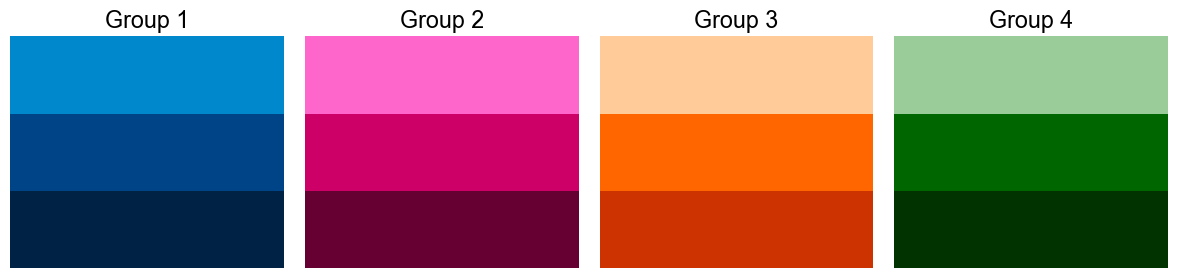

In [91]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

colors = {
    'Group 1': ['#002244', '#004488', '#0088CC'],  # Even Deeper Blues
    'Group 2': ['#660033', '#CC0066', '#FF66CC'],  # Even Deeper Purples to Light Pinks
    'Group 3': ['#CC3300', '#FF6600', '#FFCC99'],  # Even Deeper Oranges to Pale Oranges
    'Group 4': ['#003300', '#006600', '#99CC99']   # Even Deeper Greens
}

# Create figure
fig, axs = plt.subplots(1, 4, figsize=(12, 3))

# Plot each color group
for i, (group, shades) in enumerate(colors.items()):
    for j, color in enumerate(shades):
        rect = patches.Rectangle((0, j), 1, 1, facecolor=color)
        axs[i].add_patch(rect)
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(0, 3)
    axs[i].set_title(group)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

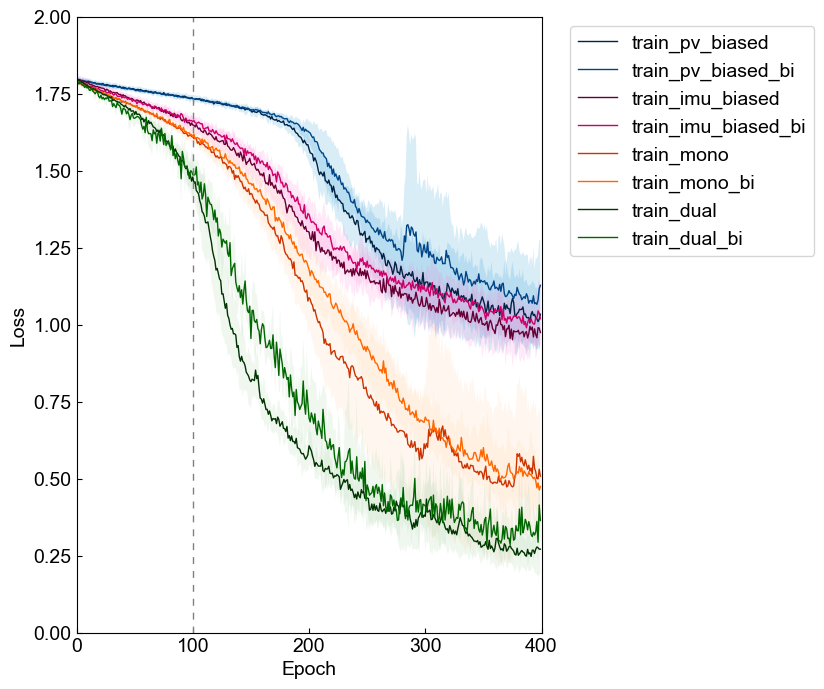

In [92]:
fig = plt.figure(figsize=[6, 8])
ax = fig.add_subplot()

ax.plot(train_losses_pv_biased_mean, linewidth=1, c=colors['Group 1'][0], label='train_pv_biased')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_pv_biased_mean - train_losses_pv_biased_std,
                train_losses_pv_biased_mean + train_losses_pv_biased_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')
# ax.plot(test_losses_pv_biased_mean, linewidth=1, c=colors['Group 1'][0], ls=(0, (5, 5)), label='test_pv_biased')
# ax.fill_between(np.arange(0, num_epochs),
#                 test_losses_pv_biased_mean - test_losses_pv_biased_std,
#                 test_losses_pv_biased_mean + test_losses_pv_biased_std,
#                 color=colors['Group 1'][2], alpha=0.15, ec='None')
ax.plot(train_losses_pv_biased_bi_mean, linewidth=1, c=colors['Group 1'][1], label='train_pv_biased_bi')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_pv_biased_bi_mean - train_losses_pv_biased_bi_std,
                train_losses_pv_biased_bi_mean + train_losses_pv_biased_bi_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')
# ax.plot(test_losses_pv_biased_bi_mean, linewidth=1, c=colors['Group 1'][1], ls=(0, (5, 5)), label='test_pv_biased_bi')
# ax.fill_between(np.arange(0, num_epochs),
#                 test_losses_pv_biased_bi_mean - test_losses_pv_biased_bi_std,
#                 test_losses_pv_biased_bi_mean + test_losses_pv_biased_bi_std,
#                 color=colors['Group 1'][2], alpha=0.15, ec='None')

ax.plot(train_losses_imu_biased_mean, linewidth=1, c=colors['Group 2'][0], label='train_imu_biased')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_imu_biased_mean - train_losses_imu_biased_std,
                train_losses_imu_biased_mean + train_losses_imu_biased_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')
# ax.plot(test_losses_imu_biased_mean, linewidth=1, c=colors['Group 2'][0], ls=(0, (5, 5)), label='test_imu_biased')
# ax.fill_between(np.arange(0, num_epochs),
#                 test_losses_imu_biased_mean - test_losses_imu_biased_std,
#                 test_losses_imu_biased_mean + test_losses_imu_biased_std,
#                 color=colors['Group 2'][2], alpha=0.15, ec='None')
ax.plot(train_losses_imu_biased_bi_mean, linewidth=1, c=colors['Group 2'][1], label='train_imu_biased_bi')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_imu_biased_bi_mean - train_losses_imu_biased_bi_std,
                train_losses_imu_biased_bi_mean + train_losses_imu_biased_bi_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')
# ax.plot(test_losses_imu_biased_bi_mean, linewidth=1, c=colors['Group 2'][1], ls=(0, (5, 5)), label='test_imu_biased_bi')
# ax.fill_between(np.arange(0, num_epochs),
#                 test_losses_imu_biased_bi_mean - test_losses_imu_biased_bi_std,
#                 test_losses_imu_biased_bi_mean + test_losses_imu_biased_bi_std,
#                 color=colors['Group 2'][2], alpha=0.15, ec='None')


ax.plot(train_losses_mono_mean, linewidth=1, c=colors['Group 3'][0], label='train_mono')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_mono_mean - train_losses_mono_std,
                train_losses_mono_mean + train_losses_mono_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')
# ax.plot(test_losses_mono_mean, linewidth=1, c=['Group 3'][0], ls=(0, (5, 5)), label='test_mono')
# ax.fill_between(np.arange(0, num_epochs),
#                 test_losses_mono_mean - test_losses_mono_std,
#                 test_losses_mono_mean + test_losses_mono_std,
#                 color=colors['Group 3'][2], alpha=0.15, ec='None')
ax.plot(train_losses_mono_bi_mean, linewidth=1, c=colors['Group 3'][1], label='train_mono_bi')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_mono_bi_mean - train_losses_mono_bi_std,
                train_losses_mono_bi_mean + train_losses_mono_bi_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')
# ax.plot(test_losses_mono_bi_mean, linewidth=1, c=['Group 3'][1], ls=(0, (5, 5)), label='test_mono_bi')
# ax.fill_between(np.arange(0, num_epochs),
#                 test_losses_mono_bi_mean - test_losses_mono_bi_std,
#                 test_losses_mono_bi_mean + test_losses_mono_bi_std,
#                 color=colors['Group 3'][2], alpha=0.15, ec='None')

ax.plot(train_losses_dual_mean, linewidth=1, c=colors['Group 4'][0], label='train_dual')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_dual_mean - train_losses_dual_std,
                train_losses_dual_mean + train_losses_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
# ax.plot(test_losses_dual_mean, linewidth=1, c=colors['Group 4'][0], ls=(0, (5, 5)), label='test_dual')
# ax.fill_between(np.arange(0, num_epochs),
#                 test_losses_dual_mean - test_losses_dual_std,
#                 test_losses_dual_mean + test_losses_dual_std,
#                 color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(train_losses_dual_bi_mean, linewidth=1, c=colors['Group 4'][1], label='train_dual_bi')
ax.fill_between(np.arange(0, num_epochs),
                train_losses_dual_bi_mean - train_losses_dual_bi_std,
                train_losses_dual_bi_mean + train_losses_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
# ax.plot(test_losses_dual_bi_mean, linewidth=1, c='#fbb4b9', ls=(0, (5, 5)), label='test_dual_bi')
# ax.fill_between(np.arange(0, num_epochs),
#                 test_losses_dual_bi_mean - test_losses_dual_bi_std,
#                 test_losses_dual_bi_mean + test_losses_dual_bi_std,
#                 color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.vlines(100, 0, 2,
          linewidth=1,
          linestyles=(0, (5, 5)),
          colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')

# plt.savefig('../results/fig3/loss.png', dpi=600, bbox_inches='tight')
plt.show()

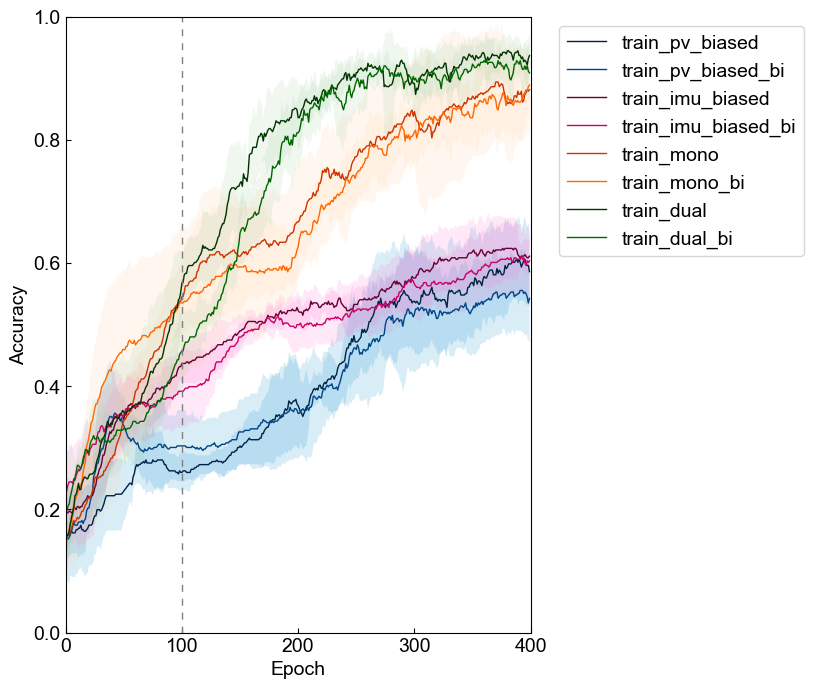

In [93]:
fig = plt.figure(figsize=[6, 8])
ax = fig.add_subplot()

ax.plot(train_accuracies_pv_biased_mean, linewidth=1, c=colors['Group 1'][0], label='train_pv_biased')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_pv_biased_mean - train_accuracies_pv_biased_std,
                train_accuracies_pv_biased_mean + train_accuracies_pv_biased_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')
# ax.plot(test_accuracies_pv_biased_mean, linewidth=1, c=colors['Group 1'][0], ls=(0, (5, 5)), label='test_pv_biased')
# ax.fill_between(np.arange(0, num_epochs),
#                 test_accuracies_pv_biased_mean - test_accuracies_pv_biased_std,
#                 test_accuracies_pv_biased_mean + test_accuracies_pv_biased_std,
#                 color=colors['Group 1'][2], alpha=0.15, ec='None')
ax.plot(train_accuracies_pv_biased_bi_mean, linewidth=1, c=colors['Group 1'][1], label='train_pv_biased_bi')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_pv_biased_bi_mean - train_accuracies_pv_biased_bi_std,
                train_accuracies_pv_biased_bi_mean + train_accuracies_pv_biased_bi_std,
                color=colors['Group 1'][2], alpha=0.15, ec='None')
# ax.plot(test_accuracies_pv_biased_bi_mean, linewidth=1, c=colors['Group 1'][1], ls=(0, (5, 5)), label='test_pv_biased_bi')
# ax.fill_between(np.arange(0, num_epochs),
#                 test_accuracies_pv_biased_bi_mean - test_accuracies_pv_biased_bi_std,
#                 test_accuracies_pv_biased_bi_mean + test_accuracies_pv_biased_bi_std,
#                 color=colors['Group 1'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_imu_biased_mean, linewidth=1, c=colors['Group 2'][0], label='train_imu_biased')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_imu_biased_mean - train_accuracies_imu_biased_std,
                train_accuracies_imu_biased_mean + train_accuracies_imu_biased_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')
# ax.plot(test_accuracies_imu_biased_mean, linewidth=0.5, c=colors['Group 2'][0], ls=(0, (5, 5)), label='test_imu_biased')
# ax.fill_between(np.arange(0, num_epochs),
#                 test_accuracies_imu_biased_mean - test_accuracies_imu_biased_std,
#                 test_accuracies_imu_biased_mean + test_accuracies_imu_biased_std,
#                 color=colors['Group 2'][2], alpha=0.15, ec='None')
ax.plot(train_accuracies_imu_biased_bi_mean, linewidth=1, c=colors['Group 2'][1], label='train_imu_biased_bi')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_imu_biased_bi_mean - train_accuracies_imu_biased_bi_std,
                train_accuracies_imu_biased_bi_mean + train_accuracies_imu_biased_bi_std,
                color=colors['Group 2'][2], alpha=0.15, ec='None')
# ax.plot(test_accuracies_imu_biased_bi_mean, linewidth=0.5, c=colors['Group 2'][1], ls=(0, (5, 5)), label='test_imu_biased_bi')
# ax.fill_between(np.arange(0, num_epochs),
#                 test_accuracies_imu_biased_bi_mean - test_accuracies_imu_biased_bi_std,
#                 test_accuracies_imu_biased_bi_mean + test_accuracies_imu_biased_bi_std,
#                 color=colors['Group 2'][2], alpha=0.15, ec='None')


ax.plot(train_accuracies_mono_mean, linewidth=1, c=colors['Group 3'][0], label='train_mono')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_mono_mean - train_accuracies_mono_std,
                train_accuracies_mono_mean + train_accuracies_mono_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')
# ax.plot(test_accuracies_mono_mean, linewidth=0.5, c=['Group 3'][0], ls=(0, (5, 5)), label='test_mono')
# ax.fill_between(np.arange(0, num_epochs),
#                 test_accuracies_mono_mean - test_accuracies_mono_std,
#                 test_accuracies_mono_mean + test_accuracies_mono_std,
#                 color=colors['Group 3'][2], alpha=0.15, ec='None')
ax.plot(train_accuracies_mono_bi_mean, linewidth=1, c=colors['Group 3'][1], label='train_mono_bi')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_mono_bi_mean - train_accuracies_mono_bi_std,
                train_accuracies_mono_bi_mean + train_accuracies_mono_bi_std,
                color=colors['Group 3'][2], alpha=0.15, ec='None')
# ax.plot(test_accuracies_mono_bi_mean, linewidth=0.5, c=['Group 3'][1], ls=(0, (5, 5)), label='test_mono_bi')
# ax.fill_between(np.arange(0, num_epochs),
#                 test_accuracies_mono_bi_mean - test_accuracies_mono_bi_std,
#                 test_accuracies_mono_bi_mean + test_accuracies_mono_bi_std,
#                 color=colors['Group 3'][2], alpha=0.15, ec='None')

ax.plot(train_accuracies_dual_mean, linewidth=1, c=colors['Group 4'][0], label='train_dual')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_dual_mean - train_accuracies_dual_std,
                train_accuracies_dual_mean + train_accuracies_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
# ax.plot(test_accuracies_dual_mean, linewidth=0.5, c=colors['Group 4'][0], ls=(0, (5, 5)), label='test_dual')
# ax.fill_between(np.arange(0, num_epochs),
#                 test_accuracies_dual_mean - test_accuracies_dual_std,
#                 test_accuracies_dual_mean + test_accuracies_dual_std,
#                 color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(train_accuracies_dual_bi_mean, linewidth=1, c=colors['Group 4'][1], label='train_dual_bi')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_dual_bi_mean - train_accuracies_dual_bi_std,
                train_accuracies_dual_bi_mean + train_accuracies_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
# ax.plot(test_accuracies_dual_bi_mean, linewidth=0.5, c=['Group 4'][1], ls=(0, (5, 5)), label='test_dual_bi')
# ax.fill_between(np.arange(0, num_epochs),
#                 test_accuracies_dual_bi_mean - test_accuracies_dual_bi_std,
#                 test_accuracies_dual_bi_mean + test_accuracies_dual_bi_std,
#                 color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.vlines(100, 0, 2,
          linewidth=1,
          linestyles=(0, (5, 5)),
          colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')

# plt.savefig('../results/fig3/accuracy.png', dpi=600, bbox_inches='tight')
plt.show()

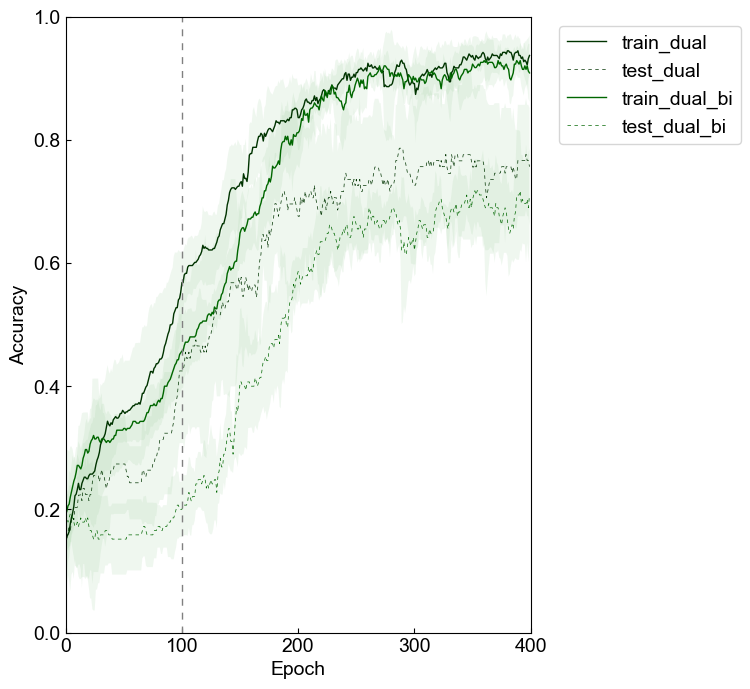

In [94]:
fig = plt.figure(figsize=[6, 8])
ax = fig.add_subplot()

ax.plot(train_accuracies_dual_mean, linewidth=1, c=colors['Group 4'][0], label='train_dual')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_dual_mean - train_accuracies_dual_std,
                train_accuracies_dual_mean + train_accuracies_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(test_accuracies_dual_mean, linewidth=0.5, c=colors['Group 4'][0], ls=(0, (5, 5)), label='test_dual')
ax.fill_between(np.arange(0, num_epochs),
                test_accuracies_dual_mean - test_accuracies_dual_std,
                test_accuracies_dual_mean + test_accuracies_dual_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(train_accuracies_dual_bi_mean, linewidth=1, c=colors['Group 4'][1], label='train_dual_bi')
ax.fill_between(np.arange(0, num_epochs),
                train_accuracies_dual_bi_mean - train_accuracies_dual_bi_std,
                train_accuracies_dual_bi_mean + train_accuracies_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')
ax.plot(test_accuracies_dual_bi_mean, linewidth=0.5, c=colors['Group 4'][1], ls=(0, (5, 5)), label='test_dual_bi')
ax.fill_between(np.arange(0, num_epochs),
                test_accuracies_dual_bi_mean - test_accuracies_dual_bi_std,
                test_accuracies_dual_bi_mean + test_accuracies_dual_bi_std,
                color=colors['Group 4'][2], alpha=0.15, ec='None')

ax.vlines(100, 0, 2,
          linewidth=1,
          linestyles=(0, (5, 5)),
          colors='gray')

ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.tick_params(which='both', direction='in')
ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')

# plt.savefig('../results/fig3/accuracy.png', dpi=600, bbox_inches='tight')
plt.show()

In [65]:
model_dual.eval()

incorrect_train_samples = []
incorrect_test_samples = []

with torch.no_grad():
    for photovoltage_data, euler_angle_data, labels in train_loader_dual:
        photovoltage_data = photovoltage_data.to(device).float()
        euler_angle_data = euler_angle_data.to(device).float()
        labels = labels.to(device)
        
        # Forward pass
        outputs = model_dual(photovoltage_data, euler_angle_data)
        _, predicted = torch.max(outputs.data, 1)

        mismatches = predicted != labels.squeeze()
        if mismatches.any():
            incorrect_predictions = (photovoltage_data[mismatches],
                                     euler_angle_data[mismatches],
                                     labels[mismatches],
                                     predicted[mismatches])
            incorrect_train_samples.extend(zip(*incorrect_predictions))

with torch.no_grad():
    for photovoltage_data, euler_angle_data, labels in test_loader_dual:
        photovoltage_data = photovoltage_data.to(device).float()
        euler_angle_data = euler_angle_data.to(device).float()
        labels = labels.to(device)
        # Forward pass
        outputs = model_dual(photovoltage_data, euler_angle_data)
        _, predicted = torch.max(outputs.data, 1)

        mismatches = predicted != labels.squeeze()
        if mismatches.any():
            incorrect_predictions = (photovoltage_data[mismatches],
                                     euler_angle_data[mismatches],
                                     labels[mismatches],
                                     predicted[mismatches])
            incorrect_test_samples.extend(zip(*incorrect_predictions))

incorrect_train_samples = incorrect_train_samples[:5]
incorrect_test_samples = incorrect_test_samples[:5]

In [66]:
def plot_incorrect_samples(samples, title):
    if device != 'cpu':
        samples_cpu = []
        for sample in samples:
            samples_cpu.append([feature.to('cpu') for feature in sample])
        samples = samples_cpu
        
    plt.figure(figsize=(15, 15))
    for i, (photovoltage, euler_angle, true_label, pred_label) in enumerate(samples):
        # Creating a subplot for each sample
        plt.subplot(len(samples), 2, 2*i + 1)  # Photovoltage plot
        plt.plot(photovoltage.numpy())  # Assuming photovoltage is a waveform
        plt.title(f'Sample {i}: True Label = {Label(true_label.item()).name}, Predicted = {Label(pred_label.item()).name}')
        plt.ylabel('Photovoltage')

        plt.subplot(len(samples), 2, 2*i + 2)  # Euler angle plot
        plt.plot(euler_angle.numpy())  # Assuming euler_angle is a waveform
        plt.ylabel('Euler Angles')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

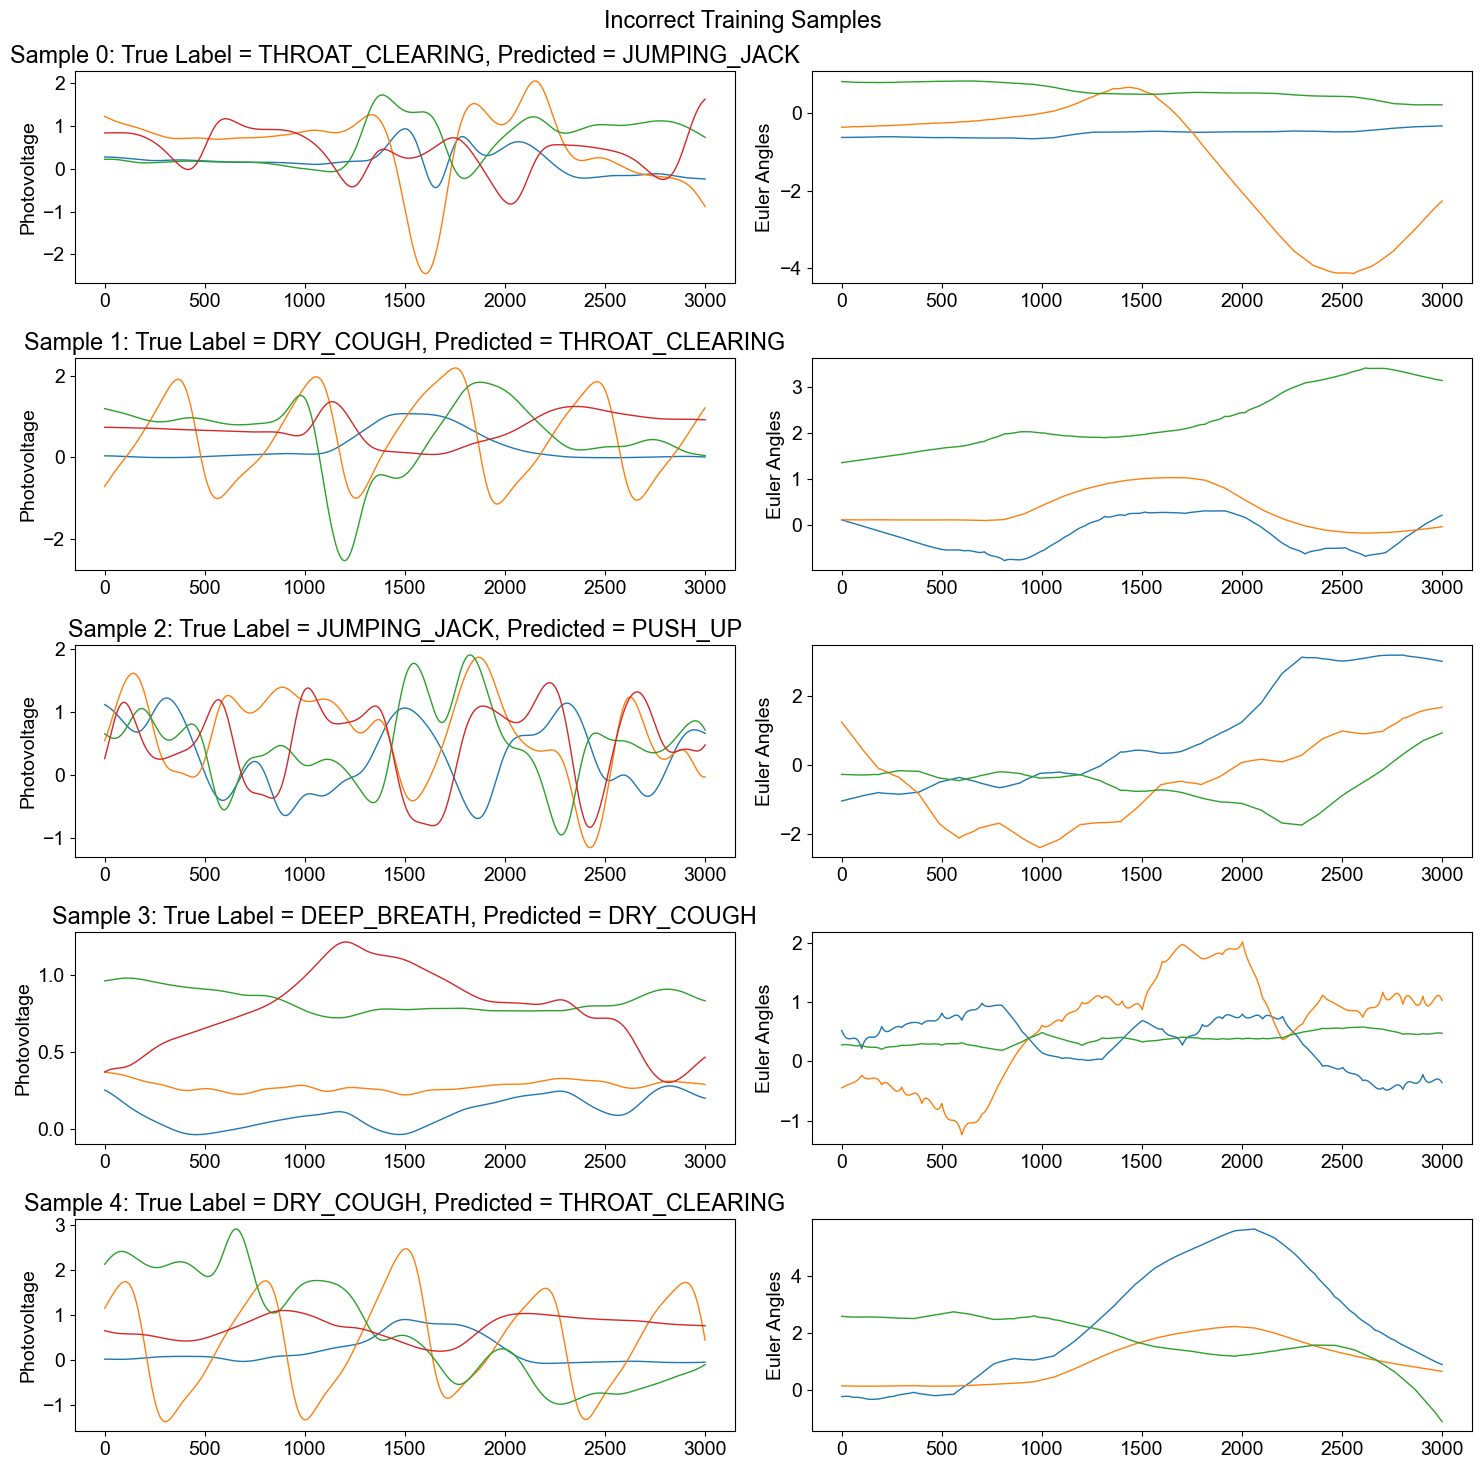

In [67]:
plot_incorrect_samples(incorrect_train_samples, "Incorrect Training Samples")

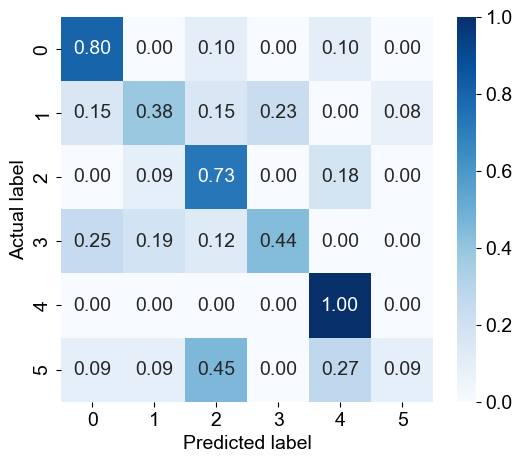

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_predictions_and_labels(model, loader):
    all_predictions = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for samples, labels in loader:
            samples = samples.to(device)
            labels = labels.to(device)
            outputs = model(samples)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_predictions, all_labels

predictions, labels = get_predictions_and_labels(model_pv_biased, train_loader_pv_biased)
cm = confusion_matrix(labels, predictions)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues')
# plt.title(title)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [79]:
normalized_cm

array([[0.81818182, 0.        , 0.        , 0.        , 0.        ,
        0.18181818],
       [0.4       , 0.6       , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.9       , 0.1       , 0.        ,
        0.        ],
       [0.        , 0.        , 0.05263158, 0.94736842, 0.        ,
        0.        ],
       [0.625     , 0.25      , 0.        , 0.        , 0.        ,
        0.125     ],
       [0.33333333, 0.16666667, 0.        , 0.        , 0.        ,
        0.5       ]])